#Библиотеки

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [ ]:
!pip install matplotlib scikit-learn transformers

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm.auto import tqdm
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
import copy
from tqdm.auto import tqdm
from datasets import DatasetDict
from transformers import TrainingArguments, Trainer, TrainerCallback
from transformers import DataCollatorWithPadding
from transformers import EarlyStoppingCallback


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

#Работа с train датасетом

In [ ]:
from google.colab import drive
import shutil



drive.mount('/content/drive/', force_remount=True)

dataset = load_dataset(
    'csv',
    data_files=f'/content/train.csv',
    column_names=['id','keyword','location', 'text', 'labels'],
)


Mounted at /content/drive/


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels'],
        num_rows: 7614
    })
})

Наш датасет очень, очень захламлён. Сам автор написал, что могут быть пустые поля в keyword и location. Давайте объективно глянем на датасет. Локаций тут тьма, кто-то пишет млечный путь, кто-то ничего, в общем это будет мешать модели установить закономерности. Также обратим внимание на ссылки, нам не важны сайты, но они начинаются с http:// и их нужно почистить, они не несут полезной информации. Также мусором можно назвать обращения,хэштеги, инородные символы. Хэштег не скажет точно ли катастрофа или нет.
Нам с этим очень помогут регулярные выражения. Ну также удалим дубликаты, нам они будут мешать при обучении, как минимум, модель может немного переобучиться от одинаковых примеров.
Тут возникла проблема. Я вместе с ненеужными тегами удаляю такие теги, как #RIP и т.п. Ну всё же иногда теги занимают чуть ли не половину всего текста. Мы можем с одной стороны дать модели хэштеги и позволить ей самой определять нужные и ненужные, но датасет очень маленький (было бы тысяч 20 хотя бы, а тут 6 тысяч без дубликатов). Мы пойдём на компромисс и превратим хэштеги #god в слова -> god

In [ ]:
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Удаление ссылок
    text = re.sub(r'@\w+', '', text)      # Удаление упоминаний
    text = re.sub(r'#', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s.,:;?!\-\']', '', text) #удаление всего not-English алфавита
    text = text.strip()                    # Удаление пробелов в начале и конце
    return text

In [ ]:
train_pd = pd.DataFrame(dataset['train'])
train_pd = train_pd.drop('id', axis=1)
train_pd = train_pd.drop('location', axis=1)
train_pd = train_pd.groupby('text', as_index=False).first()
train_pd['text'] = list(map(clean_tweet, train_pd['text']))
train_pd = train_pd.explode('text')
train_pd = train_pd.groupby('text', as_index=False).first()
train_pd = train_pd.drop_duplicates().reset_index(drop=True)
train_pd['labels'] = pd.to_numeric(train_pd['labels'], errors='coerce')
train_pd = train_pd[train_pd['labels'].isin([0, 1])].reset_index(drop=True)
train_pd['labels'] = train_pd['labels'].astype(int)
train_pd

,text,keyword,labels
0,! Residents Return To Destroyed Homes As Washi...,wildfire,1
1,' no pharrell only YOU can prevent forest fire...,forest%20fires,0
2,'...As of right now I'm reopening the X-Files....,fear,0
3,'13 M. Chapoutier Crozes Hermitage so much pur...,crushed,0
4,'54 -9 How do people not know who Kendall Jenn...,screaming,0
...,...,...,...
6906,you're the snowstorm I'm purified. the darkest...,snowstorm,0
6907,you're too busy finishing those weapon designs,weapon,0
6908,your Tweet was quoted by,quarantine,0
6909,your lifetime odds of dying from an airplane a...,airplane%20accident,0


<ipython-input-10-a8f9c9680dd1>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


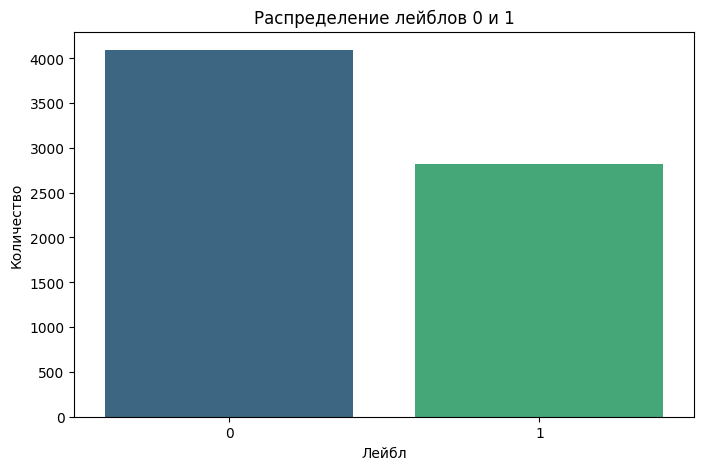

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
label_counts = train_pd['labels'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Распределение лейблов 0 и 1')
plt.xlabel('Лейбл')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()

In [ ]:
train = Dataset.from_pandas(train_pd)
train

Dataset({
    features: ['text', 'keyword', 'labels'],
    num_rows: 6911
})

Ну это выглядит поприятнее. Далее нам нужно выбрать модель и обучить. Я помню мне говорили взять какой-то простой датасет и обучить на нём две модельки и сравнить. Ну моделй очень много и я бы хотел использовать трансформеры здесь (RNN, LSTM и прочие дают результаты хуже и с ними много мучаться). Поэтому я обучу одну модель с замороженным backbone и размороженным, сравню их и сделаю выводы. Будет две модели, но я надеюсь, что это не повлиет на оценку. Я планирую в следующем семестре написать что-то мощное, чтобы сдать Елене Владимировне, это проект просто для зачёта.
Я разбирал устройство трансформера в виде класса из статьи Attention is all you need и думаю, что будет проще загрузить модель из hugging face. Остаётся только выбрать нужную. Можно вообще взять какую-нибудь базу, типо Bert

Я зашёл на hugging face и взял RoBERT, который обучен на постах из facebook. Bert и RoBert очень похожи и их реализация практически идентична, но RoBERT немного лучше. К тому же для классификации постов с твиттера будет полезна модель, которая обучена на постах в facebook

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Существует несколько способов токенизации, когда у нас несколько колонок. И самый простой - объединить два столбца и разделить их служебным токеном. Самый простой не только для меня, но и для модели. Хотя я только новичок. Хотя механизм attention вроде как параллельно всё обрабатывает, я не знаю, как будет действовать с несколькими колонками.

In [ ]:
def tokenize(dataset: Dataset, tokenizer: BertTokenizer):
    combined_text = [f"{text} [KEYWORD] {keyword}" for text, keyword in zip(dataset["text"], dataset["keyword"])]

    tokenized_text = tokenizer(
        combined_text,
        truncation=True,
        padding='max_length',
        max_length=512
    )

    return tokenized_text

In [ ]:
train = train.map(tokenize, batched=True, fn_kwargs={"tokenizer": tokenizer})
train = train.remove_columns(["keyword"])
train

Map:   0%|          | 0/6911 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6911
})

In [ ]:
train = train.train_test_split(test_size=0.10).shuffle(seed=42)
train

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6219
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 692
    })
})

Вот и выполнен Препроцессинг данных. Мы избавились от мусора, как смогли, и токенизировали текст.

#Модель

In [ ]:
from transformers import PreTrainedModel, PretrainedConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import BertModel
import torch.nn as nn


class TransformerConfig(PretrainedConfig):
    model_type = "transformer_clf"

    def __init__(self, base_transformer_model="bert-base-uncased", num_labels=2, **kwargs):
        self.base_transformer_model = base_transformer_model
        self.num_labels = num_labels
        super().__init__(**kwargs)

class TransformerClassificationModel(PreTrainedModel):
    config_class = TransformerConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.backbone = BertModel.from_pretrained(config.base_transformer_model)

        for param in self.backbone.parameters():
            param.requires_grad = False


        self.classifier = nn.Linear(self.backbone.config.hidden_size, config.num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        outputs = self.backbone(input_ids, attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(embeddings)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
from transformers import BertForSequenceClassification

bert = BertForSequenceClassification.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1
    }

#Обучение с замороженным backbone

In [ ]:
config = TransformerConfig(base_transformer_model="bert-base-uncased", num_labels=2)
bert = TransformerClassificationModel(config)

In [ ]:
import shutil
import os
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding

dir = '/content/models'
output_dir = os.path.join(dir, 'Bert')
os.makedirs(output_dir, exist_ok=True)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

batch_size = 32
num_epochs = 15
learning_rate = 2e-5
weight_decay = 0.001
evaluation_strategy = "epoch"
save_total_limit = 3
remove_unused_columns = True
report_to = "none"
padding = True
logging_steps = 1
metric_for_best_model = "eval_f1"
greater_is_better = True

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy=evaluation_strategy,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    save_total_limit=save_total_limit,
    num_train_epochs=num_epochs,
    remove_unused_columns=remove_unused_columns,
    report_to=report_to,
    logging_steps=logging_steps,
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    save_strategy="epoch",
    fp16=True
)

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=padding
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train["train"],
    eval_dataset=train["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-b0c74a1780fc>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.490300,0.405906,0.832370,0.832557,0.832370,0.832457
2,0.535700,0.374934,0.842486,0.843239,0.842486,0.840580
3,0.135300,0.464807,0.832370,0.833824,0.832370,0.832844
4,0.029700,0.528716,0.838150,0.837900,0.838150,0.836787
5,0.038400,0.678318,0.786127,0.791591,0.786127,0.787382
6,0.065100,0.812002,0.822254,0.823143,0.822254,0.819628
7,0.026300,0.889621,0.813584,0.812735,0.813584,0.812226
8,0.000800,0.999794,0.815029,0.814139,0.815029,0.814014
9,0.000700,1.076225,0.813584,0.812706,0.813584,0.812751
10,0.000500,1.200043,0.812139,0.811269,0.812139,0.811362


TrainOutput(global_step=2925, training_loss=0.11504595718392804, metrics={'train_runtime': 2428.3231, 'train_samples_per_second': 38.415, 'train_steps_per_second': 1.205, 'total_flos': 2.45443147992576e+16, 'train_loss': 0.11504595718392804, 'epoch': 15.0})

И тут я столкнулся с ужасной проблемой, а именно с Wi-Fi СУНЦа, который не поддерживает обучение. Я пытался около 13 (уже несколько дней) часов обучать, но всё сбрасывается под конец... Пока я делал эти попытки, я потратил мощности на всех трёх (уже четырёх) google аккаунтах и... У меня остался cpu, который почему-то не поддерживает обучение трансформера

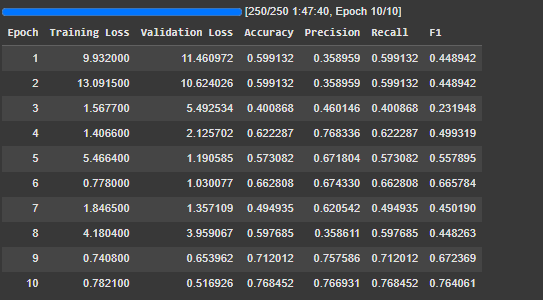

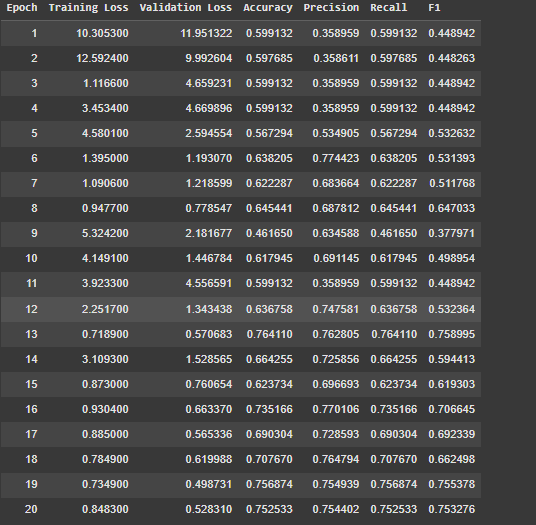

Вот финальный результат

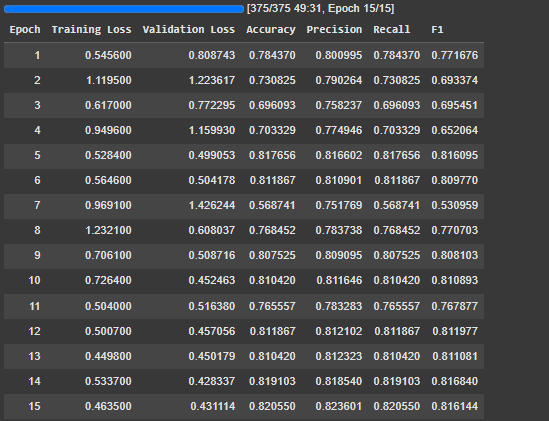

In [ ]:
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/models/Bert/tokenizer_config.json',
 '/content/models/Bert/special_tokens_map.json',
 '/content/models/Bert/vocab.txt',
 '/content/models/Bert/added_tokens.json')

In [ ]:
best_model = BertForSequenceClassification.from_pretrained(output_dir)
test_results = trainer.evaluate(eval_dataset=train["test"])
print("F1 на тестовом наборе:", test_results["eval_f1"])

F1 на тестовом наборе: 0.8405799715815363


# Препроцессинг теста

In [ ]:
drive.mount('/content/drive/', force_remount=True)

datasett = load_dataset(
    'csv',
    data_files=f'/content/test.csv',
    column_names=['id','keyword','location', 'text'],
)

Mounted at /content/drive/


In [ ]:
datasett

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3264
    })
})

In [ ]:
test_pd = pd.DataFrame(datasett['train'])
test_pd = pd.DataFrame(datasett['train'])
test_pd = test_pd.drop('id', axis=1)
test_pd = test_pd.drop('location', axis=1)
test_pd['text'] = list(map(clean_tweet, test_pd['text']))

test_pd

,keyword,text
0,keyword,text
1,None,Just happened a terrible car crash
2,None,"Heard about earthquake is different cities, st..."
3,None,"there is a forest fire at spot pond, geese are..."
4,None,Apocalypse lighting. Spokane wildfires
...,...,...
3259,None,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENER...
3260,None,Storm in RI worse than last hurricane. My city...
3261,None,Green Line derailment in Chicago
3262,None,MEG issues Hazardous Weather Outlook HWO


In [ ]:
test_pd = test_pd.drop(0)
test_pd

,keyword,text
1,None,Just happened a terrible car crash
2,None,"Heard about earthquake is different cities, st..."
3,None,"there is a forest fire at spot pond, geese are..."
4,None,Apocalypse lighting. Spokane wildfires
5,None,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3259,None,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENER...
3260,None,Storm in RI worse than last hurricane. My city...
3261,None,Green Line derailment in Chicago
3262,None,MEG issues Hazardous Weather Outlook HWO


In [ ]:
test = Dataset.from_pandas(test_pd)
test

Dataset({
    features: ['keyword', 'text'],
    num_rows: 3263
})

In [ ]:
test = test.map(tokenize, batched=True, fn_kwargs={"tokenizer": tokenizer})
test = test.remove_columns(["keyword"])
test

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [ ]:

predictions = trainer.predict(test)

In [ ]:
print(predictions)

PredictionOutput(predictions=array([[-0.88720703,  0.7192383 ],
       [-1.5361328 ,  1.2070312 ],
       [-1.1582031 ,  0.72265625],
       ...,
       [-2.0566406 ,  1.7255859 ],
       [-1.7119141 ,  1.0732422 ],
       [-1.0927734 ,  0.5288086 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 22.5963, 'test_samples_per_second': 144.404, 'test_steps_per_second': 4.514})


In [ ]:
predictions_array = predictions.predictions

In [ ]:
print(predictions_array)

[[-0.88720703  0.7192383 ]
 [-1.5361328   1.2070312 ]
 [-1.1582031   0.72265625]
 ...
 [-2.0566406   1.7255859 ]
 [-1.7119141   1.0732422 ]
 [-1.0927734   0.5288086 ]]


In [ ]:
predicted_classes = np.argmax(predictions_array, axis=1)

In [ ]:
class_counts = np.bincount(predicted_classes)

print("Количество элементов в классе 0:", class_counts[0])
print("Количество элементов в классе 1:", class_counts[1])

Количество элементов в классе 0: 2051
Количество элементов в классе 1: 1212


In [ ]:
print("Предсказанные классы:", predicted_classes)

Предсказанные классы: [1 1 1 ... 1 1 1]


In [ ]:
for pred in predictions:
  print(pred)

[[-0.88720703  0.7192383 ]
 [-1.5361328   1.2070312 ]
 [-1.1582031   0.72265625]
 ...
 [-2.0566406   1.7255859 ]
 [-1.7119141   1.0732422 ]
 [-1.0927734   0.5288086 ]]
None
{'test_runtime': 22.5963, 'test_samples_per_second': 144.404, 'test_steps_per_second': 4.514}


In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predicted_classes
sample_submission.to_csv('/content/updated_submission.csv', index=False, quoting=1)

In [ ]:
import json
def save_pretrained(self, save_directory):
    torch.save(self.state_dict(), f"{save_directory}/pytorch_model.bin")
    config = {
        "base_transformer_model": "bert-base-uncased",
        "num_labels": self.num_labels
    }
    with open(f"{save_directory}/config.json", "w") as f:
        json.dump(config, f)

TransformerClassificationModel.save_pretrained = save_pretrained
model.save_pretrained("my_model")

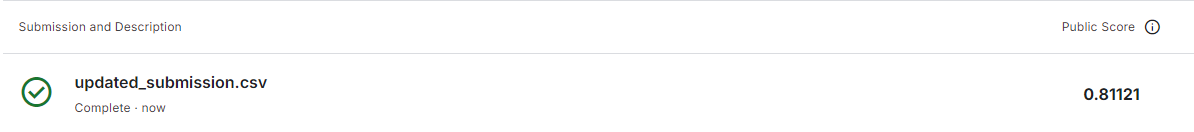

In [ ]:
model = BertForSequenceClassification.from_pretrained(output_dir)
cleaned_text = clean_tweet("@ Train Wreck caused by food accident!!!!!!!!!!!!!")
inputs = tokenizer(
    cleaned_text,
    truncation=True,
    padding="max_length",
    max_length=512,
    return_tensors="pt"
)

# Перенос данных на устройство (CPU/GPU)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

if predicted_class == 0:
    print("No disaster")
else:
    print("Oh, no, disaster!")

Oh, no, disaster!
